$G_i + P \quad[k^{b_P}_i]<->[k^{u_P}_i] \quad  G_i:P \\
G_i:P \quad  --> [k_i^{tx}] \quad  G_i + P + T_i \\
T_i + R \quad  [k^{b_R}_i]<->[k^{u_R}_i]\quad   T_i:R \\
T_i:R  \quad -->[k_i^{tl}]\quad T_i + R + X_i \\
T_i + E \quad  [k^{b_E}_i]<->[k^{u_E}_i] \quad  T_i:E \\
T_i:E \quad-->[\delta_i]\quad E \\
T \quad-->[d_T]\quad \\
X \quad-->[d]\quad $

In [1]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from autoreduce import *
import numpy as np
from sympy import symbols

In [2]:
# Post conservation law and other approximations phenomenological model at the RNA level
n = 8 # Number of states : P, C1, T, R, C2, E, C3, X
nouts = 1 # Number of outputs, X_i

# Inputs by user 
x_init = np.zeros(n)
x_init[0] = 100
x_init[3] = 400
x_init[5] = 20
C = np.zeros((nouts,n), dtype=int)
C[0][7] = 1

nstates_tol_max = 3
nsatees_tol_min = 2
error_tol = 3000
# System dynamics symbolically

# k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d = params, len(params) = 10


x0 = symbols('P')
x1 = symbols('C1') # G:P
x2 = symbols('T')
x3 = symbols('R')
x4 = symbols('C2') # T:R
x5 = symbols('E')
x6 = symbols('C3') # T:E
x7 = symbols('X')

x = [x0, x1, x2, x3, x4, x5, x6, x7]

G = symbols('G')
k_bp = symbols('k_bp')
k_up = symbols('k_up')
k_tx = symbols('k_tx')
k_br = symbols('k_br')
k_ur = symbols('k_ur')
k_tl = symbols('k_tl')
k_be = symbols('k_be')
k_ue = symbols('k_ue')
d_i = symbols('d_i')
d = symbols('d')
d_T = symbols('d_T')

E_tot = symbols('E_tot')
P_tot = symbols('P_tot')
R_tot = symbols('R_tot')
params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
# f0 = (k_bp + k_tx) * x1 - k_up * G * x0
f0 = (k_up + k_tx) * x1 - k_bp * G * x0
f1 = k_bp * G * x0 - (k_up + k_tx)*x1
f2 = k_tx * x1 + (k_ur + k_tl) * x4 + k_ue * x6 - k_br * x2 * x3 - k_be * x2 * x5 - d_T * x2
f3 = (k_ur + k_tl) * x4 - k_br * x2 * x3
f4 = k_br * x2 * x3 - (k_ur + k_tl) * x4
f5 = (k_ue + d_i) * x6 - k_be * x2 * x5
f6 = k_be * x2 * x5 - (k_ue + d_i) * x6
f7 = k_tl * x4 - d * x7
    
f = [f0,f1,f2,f3,f4,f5,f6,f7]
# parameter values
# E_tot = 20
# P_tot = 100
# R_tot = 400
params_values = [30, 10, 0.50, 80, 2, 8, 10, 2, 1, 0.5, 0.01, 20, 100, 400, 10]
# params_values = [100, 10, 4, 10, 0.25, 2, 10, 0.5, 1, 1, 1000, 1000, 1000, 10]
sys = System(x, f, params = params, params_values = params_values, C = C, x_init = x_init)

Text(0.5, 0, 'Time')

Text(0, 0.5, '[Outputs]')

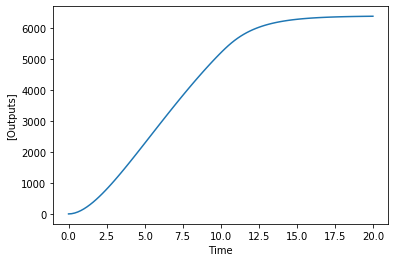

In [3]:
from autoreduce.utils import get_ODE
timepoints_ode = np.linspace(0, 20, 100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
try:
    import matplotlib.pyplot as plt
    plt.plot(timepoints_ode, np.transpose(np.array(C)@sol))
    plt.xlabel('Time')
    plt.ylabel('[Outputs]')
    plt.show()
except:
    print('Plotting libraries missing.')

In [4]:
from autoreduce.utils import get_reducible
timepoints_ssm = np.linspace(0,2,10)
timepoints_ode = np.linspace(0,2,100)
sys_reduce = get_reducible(sys, timepoints_ode, timepoints_ssm)
sys_reduce.nstates_tol_min = 2
sys_reduce.nstates_tol_max = 3

In [5]:
P, C1, T, R, C2, E, C3, X = sys.x
conserved_quantities = [P + C1 - P_tot, R + C2 - R_tot, E + C3 - E_tot]
states_to_eliminate = [C1, C2, C3]
f_cons = sys_reduce.set_conservation_laws(conserved_quantities, states_to_eliminate)

In [6]:
f_cons

[-G*P*k_bp + (-P + P_tot)*(k_tx + k_up),
 -E*T*k_be - R*T*k_br - T*d_T + k_tx*(-P + P_tot) + k_ue*(-E + E_tot) + (-R + R_tot)*(k_tl + k_ur),
 -R*T*k_br + (-R + R_tot)*(k_tl + k_ur),
 -E*T*k_be + (-E + E_tot)*(d_i + k_ue),
 -X*d + k_tl*(-R + R_tot)]

Text(0.5, 0, 'Time')

Text(0, 0.5, '[X]')

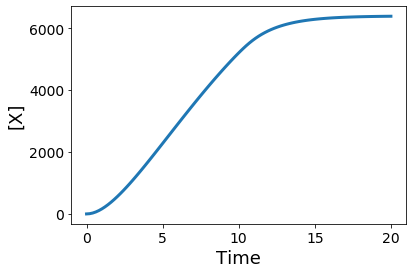

In [7]:
from autoreduce.utils import get_ODE
timepoints_ode = np.linspace(0, 20, 100)
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, E_tot, P_tot, R_tot, G]
# params_values = [100, 10, 4, 10, 0.25, 2, 10, 0.5, 1, 10, 10000, 10000, 10000, 0.01]
# params_values = [30, 10, 0.50, 80, 2, 8, 10, 2, 1, 0.5, 0.01, 20, 100, 400, 10]
# sys_reduce.params_values = params_values
sys_ode = get_ODE(sys_reduce, timepoints_ode)
sol = sys_ode.solve_system().T
try:
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol), linewidth = 3)
    plt.xlabel('Time', FontSize = 18)
    plt.ylabel('[X]', FontSize = 18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    # plt.legend()
    plt.show()
except:
    print('Plotting libraries missing.')

In [8]:
sys_reduce.f

[-G*P*k_bp + (-P + P_tot)*(k_tx + k_up),
 -E*T*k_be - R*T*k_br - T*d_T + k_tx*(-P + P_tot) + k_ue*(-E + E_tot) + (-R + R_tot)*(k_tl + k_ur),
 -R*T*k_br + (-R + R_tot)*(k_tl + k_ur),
 -E*T*k_be + (-E + E_tot)*(d_i + k_ue),
 -X*d + k_tl*(-R + R_tot)]

In [9]:
sys_reduce.x

[P, T, R, E, X]

In [10]:
reduced_sys, fast_ss = sys_reduce.solve_timescale_separation([T,R,X], fast_states = [E, P], debug = False)


Successful time-scale separation solution obtained with states: [T, R, X]!


In [11]:
reduced_sys.f[1]

-R*T*k_br + (-R + R_tot)*(k_tl + k_ur)

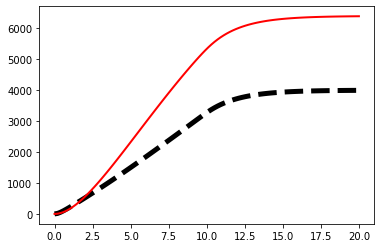

In [12]:
try:
    fig, ax = plt.subplots() 
    # params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
    params_values_new = [80, 2, 0.5, 80, 2, 5, 80, 2, 0.1, 0.5, 0.05, 100, 100, 400, 10]
    sys_reduce.params_values = params_values_new

    sys_ode = get_ODE(sys_reduce, timepoints_ode)
    sol = sys_ode.solve_system().T
    _ = plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
    reduced_ode = get_ODE(reduced_sys, timepoints_ode)
    reduced_sol = reduced_ode.solve_system().T
    _ = plt.plot(timepoints_ode, np.transpose(np.array(reduced_sys.C)@reduced_sol), 'r', label = 'Reduced model', linewidth = 2)
    plt.show()
except:
    print('Plotting libraries missing.')

In [13]:
# results = sys_reduce.reduce_simple(skip_numerical_computations = True, debug = True)
reduced_sys, fast_ss = sys_reduce.solve_timescale_separation([T,R,X], debug = False)
# se1 = sys_reduce.get_robustness_metric(reduced_sys)
# e1 = sys_reduce.get_error_metric(reduced_sys)


Successful time-scale separation solution obtained with states: [T, R, X]!


In [14]:
reduced_sys, fast_ss = sys_reduce.solve_timescale_separation([T, R, X])
reduced_sys.f[1]
# from auto_reduce.utils import get_ODE
x_sol_hat = get_ODE(sys_reduce.get_system(), timepoints_ode).solve_system()

Successful time-scale separation solution obtained with states: [T, R, X]!


-R*T*k_br + (-R + R_tot)*(k_tl + k_ur)